In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [ ]:
# Define your data directory
data_dir = '/content/drive/MyDrive/breed_data'
model_versions_dir = '/content/drive/MyDrive/model_versions_dir/models'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.set_num_threads(4)

In [ ]:
# Define your transforms for data augmentation and normalization
data_transforms = {
    # No augmenting
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(
    root=f"{data_dir}/{x}",
    transform=data_transforms[x]
) for x in ['train', 'valid', 'test']}

# Create dataloaders for batch processing
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x],
    batch_size=128,
    shuffle=True,
    num_workers=4
) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


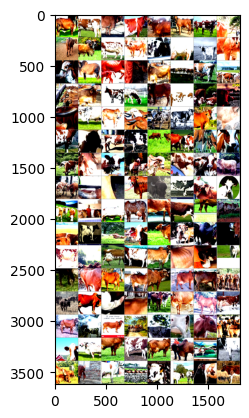

In [ ]:
# Define a function to show an image
def get_image_to_plot(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    transposed_img = np.transpose(npimg, (1, 2, 0))
    return transposed_img

def imshow(img):
    img = get_image_to_plot(img)
    plt.imshow(img)
    plt.show()


# Get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
def show_class_distribution(dataloader, dataset_name):
    labels = []
    dataset = dataloader[dataset_name]

    # Collect labels from the dataset
    for _, target in dataset:
        labels.extend(target.tolist())

    # Count occurrences of each unique label
    class_counts = Counter(labels)

    # Extract labels and counts for plotting
    class_labels, class_counts = zip(*class_counts.items())

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Class Distribution - {dataset_name.capitalize()} Dataset')
    plt.show()


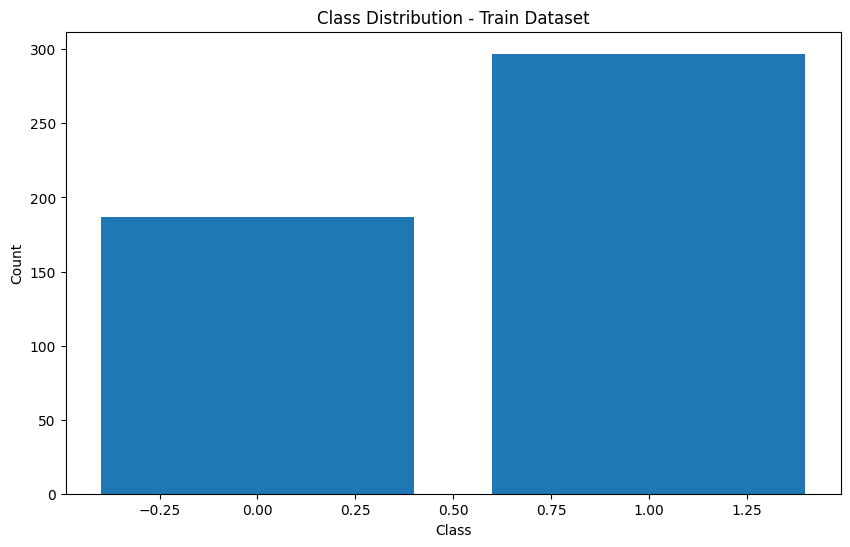

In [ ]:
show_class_distribution(dataloaders, "train")  # Show train dataset distribution


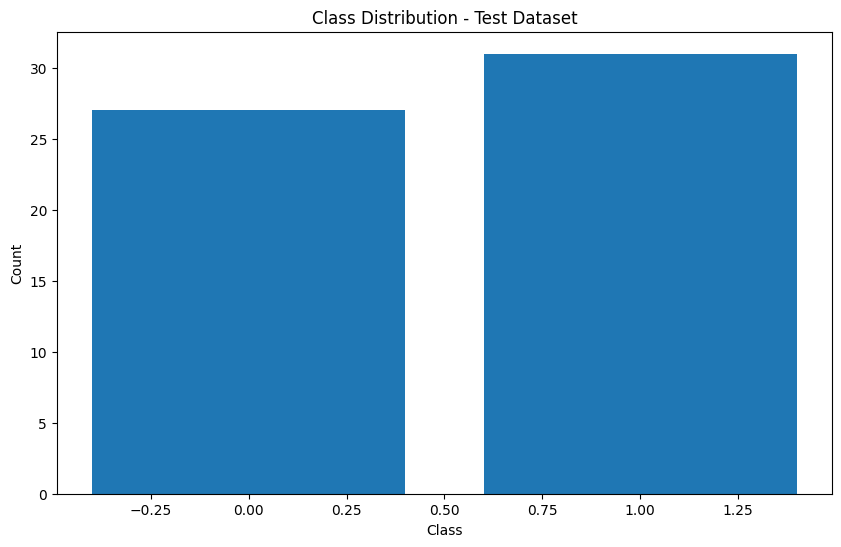

In [ ]:
show_class_distribution(dataloaders, "test")   # Show test dataset distribution


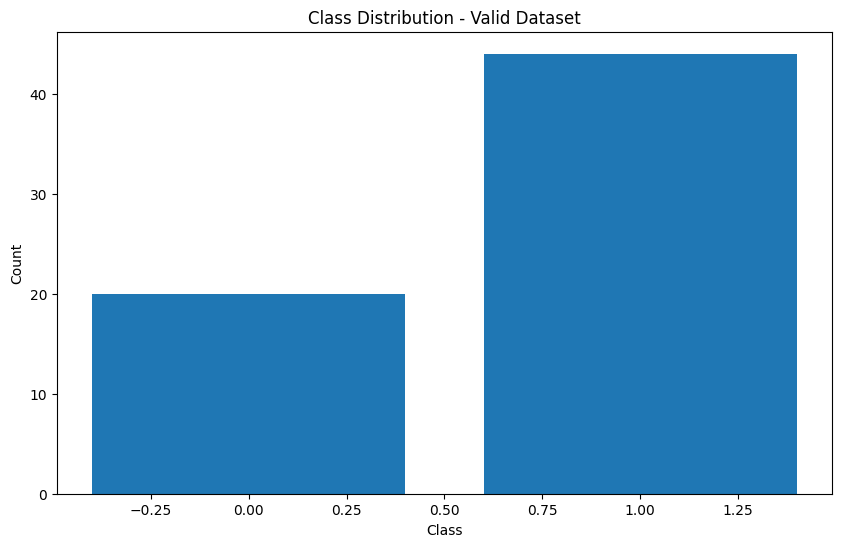

In [ ]:
show_class_distribution(dataloaders, "valid")    # Show validation dataset distribution


In [ ]:
def train_model(model, criterion, optimizer, trainloader, validloader, num_epochs=20, plotname='noname'):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate and store the average training loss for the epoch
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total

        print(f'[{epoch + 1} / {num_epochs}] Training loss: {train_loss:.6f} | Training accuracy: {train_accuracy:.6f}%')


        # Validation
        model.eval()  # Set the model to evaluation mode
        valid_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for data in validloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate and store the average validation loss for the epoch
        valid_loss /= len(validloader)
        valid_accuracy = 100 * correct / total

        print(f'[{epoch + 1} / {num_epochs}] Validation loss: {valid_loss:.6f} | Validation accuracy: {valid_accuracy:.6f}%')

    print('Finished Training')

In [ ]:
# Load a pretrained model
model_ft = models.resnet50(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


In [ ]:
num_ftrs = model_ft.fc.in_features
num_classes = len(dataloaders['train'].dataset.classes)
num_ftrs, num_classes

(2048, 2)

In [ ]:
# Freeze convolutional layers
for param in model_ft.parameters():
    param.requires_grad = False

# Set fully connected layer
fc_layers = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, num_classes)
)

model_ft.fc = fc_layers
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.parameters(), lr=0.01)

In [ ]:
train_model(model_ft, criterion, optimizer, dataloaders['train'], dataloaders['valid'], num_epochs=10, plotname='resnet50/layer fc')

[1 / 10] Training loss: 0.671027 | Training accuracy: 57.024793%
[1 / 10] Validation loss: 0.612246 | Validation accuracy: 68.750000%
[2 / 10] Training loss: 0.634499 | Training accuracy: 61.363636%
[2 / 10] Validation loss: 0.578151 | Validation accuracy: 68.750000%
[3 / 10] Training loss: 0.603519 | Training accuracy: 61.776860%
[3 / 10] Validation loss: 0.547543 | Validation accuracy: 70.312500%
[4 / 10] Training loss: 0.579237 | Training accuracy: 63.016529%
[4 / 10] Validation loss: 0.525296 | Validation accuracy: 76.562500%
[5 / 10] Training loss: 0.552457 | Training accuracy: 70.661157%
[5 / 10] Validation loss: 0.496726 | Validation accuracy: 78.125000%
[6 / 10] Training loss: 0.528162 | Training accuracy: 73.966942%
[6 / 10] Validation loss: 0.474456 | Validation accuracy: 81.250000%
[7 / 10] Training loss: 0.508886 | Training accuracy: 77.685950%
[7 / 10] Validation loss: 0.450175 | Validation accuracy: 82.812500%
[8 / 10] Training loss: 0.481785 | Training accuracy: 82.23140

In [ ]:
def test_model(model, dataloader, class_names, n=5):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0

    num_images = min(n, len(dataloader.dataset))

    with torch.no_grad():
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 3))

        for i, data in enumerate(dataloader):
            if i >= num_images:
                break

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Convert tensor to numpy array
            image = get_image_to_plot(inputs[0].cpu())
            image = np.clip(image, 0, 1)  # Clip pixel values between 0 and 1

            # Plot the image and show the actual and predicted class names
            ax = axes[i]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f'Actual: {class_names[labels[0]]}\nPredicted: {class_names[predicted[0]]}')

        plt.tight_layout()
        plt.show()

    test_accuracy = 100 * correct / total
    print(f'Test accuracy: {test_accuracy:.6f}%')


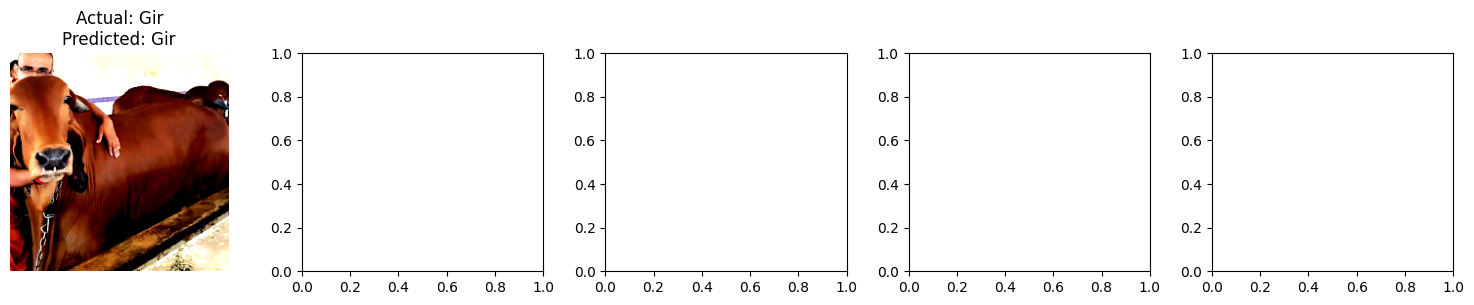

Test accuracy: 91.379310%


In [ ]:
test_model(model_ft, dataloaders['test'], class_names)

In [ ]:
# Save model
torch.save(model_ft.state_dict(), model_versions_dir + 'resnet50')

In [ ]:
# Load model
model_ft.load_state_dict(torch.load(model_versions_dir + 'resnet50'))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [1]:
!zip -r project_files.zip /content/
from google.colab import files
files.download("project_files.zip")


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.09.02/ (stored 0%)
  adding: content/.config/logs/2025.09.02/13.40.25.412517.log (deflated 57%)
  adding: content/.config/logs/2025.09.02/13.40.24.646161.log (deflated 57%)
  adding: content/.config/logs/2025.09.02/13.40.02.703385.log (deflated 58%)
  adding: content/.config/logs/2025.09.02/13.39.41.819003.log (deflated 92%)
  adding: content/.config/logs/2025.09.02/13.40.13.974509.log (deflated 58%)
  adding: content/.config/logs/2025.09.02/13.40.12.652972.log (deflated 87%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>